# Import

In [1]:
import sys

root_dir = '../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Dataset

In [2]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

# device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

# Evaluator

In [3]:
# k
ks = [5, 10, 50]

score_function_dict = {
    "Recall"      : evaluators.recall,
    "Unpopularity": evaluators.unpopularity,
    "Unpopularity2": evaluators.unpopularity2,
    "Unpopularity3": evaluators.unpopularity3,
    "F1-score"    : evaluators.f1_score,
    "F1-score2"    : evaluators.f1_score2,
    "F1-score3"    : evaluators.f1_score3
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)
# coverage = evaluators.CoverageEvaluator(test_set, ks)
# hubness = evaluators.HubnessEvaluator(test_set, ks)

# Sampler

In [4]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [5]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# No Training Result

In [6]:
knn = searches.NearestNeighborhood(model)
trainer.valid(knn, userwise)
re_no_training = trainer.valid_scores.copy()
display(re_no_training)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.060736,0.969839,6.614456,0.062429,0.095432,0.115758,0.030704,0.117845,0.969755,6.619698,0.124785,0.178578,0.22367,0.087656,0.526773,0.917473,6.281484,0.524191,0.580685,0.927078,0.516366


# Training

In [7]:
# only traing no validation
trainer.fit(n_batch, n_epoch)

# Result

## Base CML

In [8]:
knn = searches.NearestNeighborhood(model)

# Recall
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()
display(re_base)

,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.399057,0.877333,3.31857,0.014166,0.490935,0.680891,0.024508,0.569553,0.891143,3.639193,0.049914,0.648901,0.960817,0.081598,0.886224,0.888168,4.767299,0.437305,0.870738,1.485369,0.512332


## CML+MP

In [9]:
n_item_sample = 30
n_user_sample = 30
bias_li = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = distributions.Gamma()

In [10]:
re_mpcml_li = []
for bias in bias_li:
    print(f'bias={bias}')
    mp = searches.MutualProximity(model, gamma, n_item_sample, n_user_sample, bias)
    trainer.valid(mp, userwise)
    re = trainer.valid_scores.copy()
    display(re)
    re_mpcml_li.append(re)

bias=0.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.22515,0.949351,5.478698,0.051337,0.313191,0.412934,0.059822,0.356387,0.953686,5.720025,0.112158,0.461148,0.647225,0.143826,0.772754,0.910552,5.823725,0.507379,0.795764,1.338608,0.578195


bias=0.1


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.2676,0.938194,4.809353,0.045151,0.365115,0.486078,0.060414,0.405503,0.945575,5.197014,0.103387,0.514016,0.72961,0.144707,0.793231,0.908431,5.683202,0.501043,0.812374,1.370371,0.575725


bias=0.2


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.288858,0.934288,4.59272,0.041117,0.387807,0.520953,0.05816,0.434786,0.941367,4.973008,0.098037,0.540135,0.776241,0.14183,0.810959,0.906307,5.554867,0.494108,0.824769,1.396,0.571183


bias=0.3


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.295972,0.930626,4.45737,0.039015,0.395247,0.531926,0.057431,0.45284,0.937671,4.804925,0.093159,0.556651,0.803877,0.137907,0.826053,0.904226,5.438443,0.487379,0.835592,1.417361,0.56627


bias=0.4


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.309668,0.927221,4.345024,0.036842,0.408761,0.553558,0.055092,0.469791,0.93366,4.646803,0.088067,0.572274,0.829715,0.133611,0.841217,0.902144,5.330951,0.480392,0.845268,1.438111,0.560834


bias=0.5


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.320353,0.924232,4.244111,0.033921,0.419207,0.569616,0.052149,0.487894,0.930592,4.531294,0.083005,0.586243,0.855932,0.12732,0.854204,0.90005,5.227139,0.472919,0.85326,1.454632,0.553947


bias=0.6


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.334459,0.920669,4.133769,0.031739,0.433196,0.591884,0.049964,0.505,0.926761,4.405216,0.078263,0.600589,0.880469,0.122623,0.862679,0.89805,5.135209,0.465941,0.858317,1.464561,0.547064


bias=0.7


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.338591,0.918003,4.056586,0.029114,0.435884,0.596412,0.046351,0.517132,0.923476,4.301115,0.073488,0.609592,0.897158,0.117022,0.872064,0.89605,5.046544,0.458985,0.863563,1.475151,0.539597


bias=0.8


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.351284,0.913137,3.942257,0.026312,0.4497,0.616135,0.043499,0.53411,0.918596,4.16929,0.067923,0.622789,0.919802,0.109355,0.87904,0.893644,4.950264,0.451309,0.867332,1.481964,0.530954


bias=0.9


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.361166,0.906954,3.797522,0.022235,0.45713,0.628666,0.037032,0.545357,0.911666,4.007557,0.060607,0.630259,0.932477,0.098454,0.884815,0.891151,4.859538,0.444132,0.870477,1.486934,0.521928


bias=1.0


,Recall@5,Unpopularity@5,Unpopularity2@5,Unpopularity3@5,F1-score@5,F1-score2@5,F1-score3@5,Recall@10,Unpopularity@10,Unpopularity2@10,Unpopularity3@10,F1-score@10,F1-score2@10,F1-score3@10,Recall@50,Unpopularity@50,Unpopularity2@50,Unpopularity3@50,F1-score@50,F1-score2@50,F1-score3@50
0,0.399054,0.877617,3.321895,0.014183,0.490651,0.680782,0.024542,0.569271,0.891224,3.640182,0.049914,0.648565,0.960351,0.081598,0.886224,0.888168,4.767299,0.437305,0.870738,1.485369,0.512332


In [11]:
re_recall = []
re_unpop1 = []
re_unpop2 = []
re_unpop3 = []
for re in re_mpcml_li:
    re_recall.append(re.iloc[-1, 7])
    re_unpop1.append(re.iloc[-1, 8])
    re_unpop2.append(re.iloc[-1, 9])
    re_unpop3.append(re.iloc[-1, 10])

## Recall vs Unpopularity1

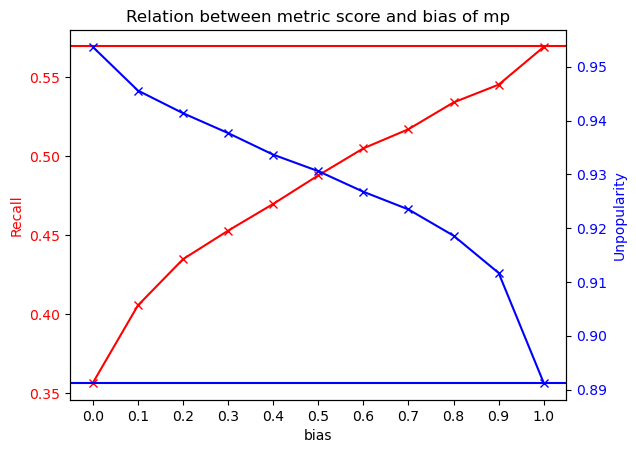

In [12]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop1, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 8], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 8], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity2

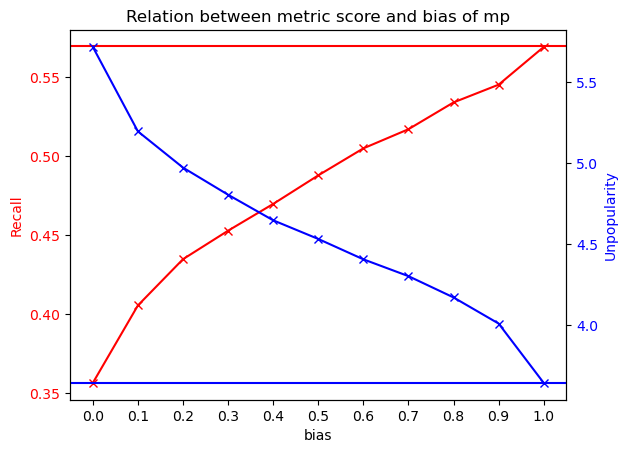

In [13]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop2, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 9], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 9], color='blue', linestyle='--')

# グラフの表示
plt.show()

## Recall vs Unpopularity3

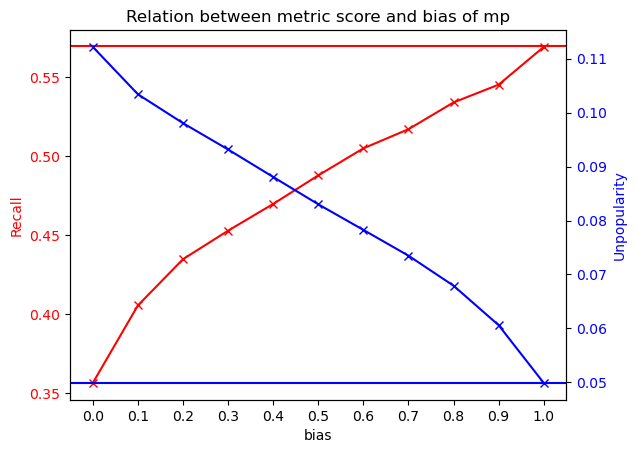

In [14]:
# グラフの描画
fig, ax1 = plt.subplots()

# Y軸1 (左側の軸) の設定
ax1.set_xlabel('bias')
ax1.set_ylabel('Recall', color='red')
ax1.plot(bias_li, re_recall, color='red', marker='x')
ax1.tick_params(axis='y', labelcolor='red')

# Y軸2 (右側の軸) の設定
ax2 = ax1.twinx()
ax2.set_ylabel('Unpopularity', color='blue')
ax2.plot(bias_li, re_unpop3, color='blue', marker='x')
ax2.tick_params(axis='y', labelcolor='blue')

# グラフのタイトルとX軸のメモリの設定
plt.title('Relation between metric score and bias of mp')
ax1.set_xticks(bias_li)
ax1.set_xticklabels(bias_li)

# 基準線の設定
# Base CML
ax1.axhline(re_base.iloc[-1, 7], color='red', linestyle='-')
ax2.axhline(re_base.iloc[-1, 10], color='blue', linestyle='-')
# No training
# ax1.axhline(re_no_training.iloc[-1, 7], color='red', linestyle='--')
# ax2.axhline(re_no_training.iloc[-1, 10], color='blue', linestyle='--')

# グラフの表示
plt.show()